In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Librerías para arboles de decision 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Librerias para regresión logística
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Libreria para trabajar cadenas de texto
import re

In [2]:
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/Titanic.csv'
df = pd.read_csv(url, sep = ',')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Antes de entrenar, completo valores vacíos de la variable edad: 
edad_mediana = df['Age'].median()
df['Age_Completa'] = df['Age'].fillna(edad_mediana,
                                      inplace = False)
df['Age_Completa'].isnull().value_counts()

False    891
Name: Age_Completa, dtype: int64

In [5]:
# Genero predictores: SEX
sexo_sup = df[['Survived','Sex']].groupby(by=['Sex']).mean().reset_index()
sexo_sup.rename(columns={'Survived': 'Sex_Surv'}, inplace=True)
df = df.merge(sexo_sup,
              left_on = 'Sex',
              right_on = 'Sex',
              how = 'left')

In [6]:
pclass_sup = df[['Survived','Pclass']].groupby(by=['Pclass']).mean().reset_index()
pclass_sup.rename(columns={'Survived': 'Pclass_Surv'}, inplace=True)
df = df.merge(pclass_sup,
              left_on = 'Pclass',
              right_on = 'Pclass',
              how = 'left')

# Modelo Base

In [7]:
# Genero el modelo
formula = "Survived ~ Sex_Surv + Pclass_Surv + Age_Completa"
reg_log = smf.logit(formula, data = df).fit()

# Ver coeficientes y p valores
coeficientes = reg_log.params
pvalores = reg_log.pvalues
print("")
print("Coeficientes:")
print(coeficientes.round(4))
print("")
print("P-Values:")
print(pvalores.round(6))

Optimization terminated successfully.
         Current function value: 0.452392
         Iterations 6

Coeficientes:
Intercept      -3.7744
Sex_Surv        4.7150
Pclass_Surv     5.9027
Age_Completa   -0.0325
dtype: float64

P-Values:
Intercept       0.000000
Sex_Surv        0.000000
Pclass_Surv     0.000000
Age_Completa    0.000009
dtype: float64


In [9]:
# Predicciones 
df['Predict_Prob_RegLog_1'] = reg_log.predict(df)

In [10]:
# Groupby por prediccion de decil: 
bin_edges = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = range(1, 11)
df['Predict_RegLog_Bin_1'] = pd.cut(df['Predict_Prob_RegLog_1'], 
                                  bins=bin_edges, 
                                  labels=bin_labels, 
                                  include_lowest=True)

In [11]:
resultados_nodo = df.groupby('Predict_RegLog_Bin_1').agg(     
    Cant = ('Predict_RegLog_Bin_1', 'count'),              
    Cant_Sup = ('Survived', 'sum'),            
    Tasa_Sup = ('Survived', 'mean')    
).reset_index()
resultados_nodo

,Predict_RegLog_Bin_1,Cant,Cant_Sup,Tasa_Sup
0,1,245,30,0.122449
1,2,127,20,0.157480
2,3,80,9,0.112500
3,4,50,12,0.240000
4,5,76,34,0.447368
5,6,81,43,0.530864
6,7,44,24,0.545455
7,8,39,27,0.692308
8,9,79,75,0.949367
9,10,70,68,0.971429


Text(0.5, 1.0, 'Tasa de supervivencia según Estimación 1')

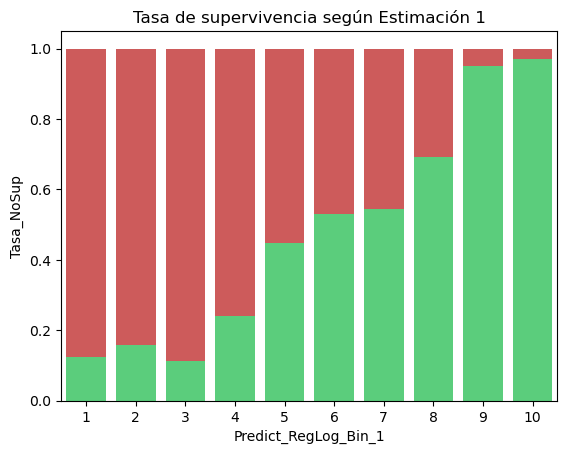

In [12]:
# Barplot por nodo 
resultados_nodo['Tasa_NoSup'] = (1 - resultados_nodo['Tasa_Sup'])
sns.barplot(data = resultados_nodo,
            x = 'Predict_RegLog_Bin_1',
            y = 'Tasa_Sup', 
            label = 'Porcentaje Supervivencia',
            color = '#48E074')
sns.barplot(data=resultados_nodo, 
            x = 'Predict_RegLog_Bin_1', 
            y = 'Tasa_NoSup', 
            bottom=resultados_nodo['Tasa_Sup'], 
            label = 'Porcentaje No Supervivencia',
            color = '#E04848')
plt.title('Tasa de supervivencia según Estimación 1')

Text(0.5, 1.0, 'Distribución de personas según Estimación')

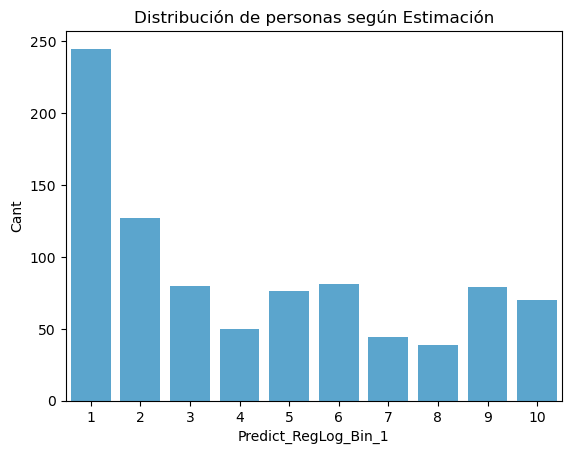

In [13]:
# Distribución
sns.barplot(data = resultados_nodo,
            x = 'Predict_RegLog_Bin_1',
            y = 'Cant',
           color = '#48ABE0')
plt.title('Distribución de personas según Estimación')

# Modelo 2
Vamos a intentar incorporar más variables. 

In [14]:
# Genero variable Contiene_Master
df['Contiene_Master'] = np.where(df['Name'].str.contains(pat = 'Master.',regex = True) == True,1,0)
resultados_var = df.groupby('Contiene_Master').agg(     
    Cant = ('Contiene_Master', 'count'),              
    Cant_Sup = ('Survived', 'sum'),            
    Tasa_Sup = ('Survived', 'mean')    
).reset_index()
resultados_var

,Contiene_Master,Cant,Cant_Sup,Tasa_Sup
0,0,851,319,0.374853
1,1,40,23,0.575000


In [15]:
# Relleno la variable fare
fare_mediana = df['Fare'].median()
df['Fare_Completa'] = df['Fare'].fillna(fare_mediana,
                                      inplace = False)
df['Fare_Completa'].isnull().value_counts()

False    891
Name: Fare_Completa, dtype: int64

<Axes: xlabel='PassengerId', ylabel='Fare'>

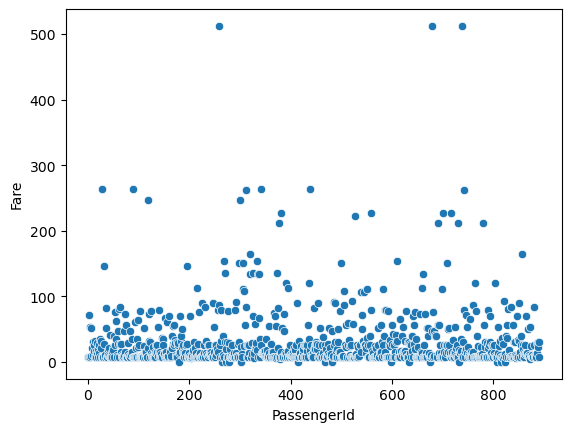

In [22]:
# Grafico para visualizar outliers
plt.figure()
sns.scatterplot(data = df,
                x = 'PassengerId',
                y = 'Fare')

<Axes: xlabel='PassengerId', ylabel='Fare_Topeada'>

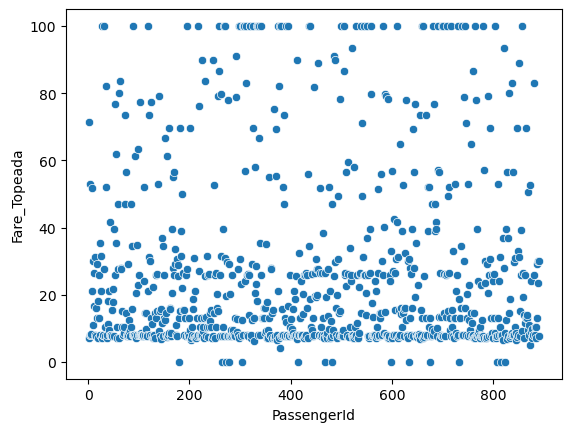

In [24]:
# Tratamiento de outlier
df['Fare_Topeada'] = np.where(df['Fare_Completa'] > 100,100,df['Fare_Completa'])
# Con tratamiento y todo, no me convencen los resultados así que la descarto igual. 
# Grafico para visualizar outliers
plt.figure()
sns.scatterplot(data = df,
                x = 'PassengerId',
                y = 'Fare_Topeada')

In [34]:
# Transformo la edad en logaritmo 
df['Age_LOG'] = np.log((df['Age_Completa'] + 1))
# mmmm no me convence

In [43]:
# Genero predictores por grupos de edad
bin_edges = [0, 5, 15, 60, 200]
bin_labels = range(1, 5)
df['Age_BIN'] = pd.cut(df['Age_Completa'], 
                                  bins=bin_edges, 
                                  labels=bin_labels, 
                                  include_lowest=True)


In [44]:
EDAD_SUP = df[['Survived','Age_BIN']].groupby(by=['Age_BIN']).mean().reset_index()
EDAD_SUP

,Age_BIN,Survived
0,1,0.704545
1,2,0.461538
2,3,0.366412
3,4,0.227273


In [46]:
EDAD_SUP.rename(columns={'Survived': 'Age_Surv'}, inplace=True)
df = df.merge(EDAD_SUP,
              left_on = 'Age_BIN',
              right_on = 'Age_BIN',
              how = 'left')

In [47]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Predict_Prob_RegLog_1,Predict_RegLog_Bin_1,Contiene_Master,Fare_Completa,Predict_Prob_RegLog_2,Predict_RegLog_Bin_2,Fare_Topeada,Age_LOG,Age_BIN,Age_Surv
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.102615,2,0,7.2500,0.068722,1,7.2500,3.135494,3,0.366412
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0.900712,10,0,71.2833,0.916696,10,71.2833,3.663562,3,0.366412
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.576751,6,0,7.9250,0.565452,6,7.9250,3.295837,3,0.366412
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0.909101,10,0,53.1000,0.918058,10,53.1000,3.583519,3,0.366412
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.069705,1,0,8.0500,0.062554,1,8.0500,3.583519,3,0.366412


In [48]:
# Genero el modelo
formula = "Survived ~ Sex_Surv + Pclass_Surv + Age_Surv + Contiene_Master"
reg_log_2 = smf.logit(formula, data = df).fit()

# Ver coeficientes y p valores
coeficientes = reg_log_2.params
pvalores = reg_log_2.pvalues
print("")
print("Coeficientes:")
print(coeficientes.round(4))
print("")
print("P-Values:")
print(pvalores.round(6))

Optimization terminated successfully.
         Current function value: 0.436945
         Iterations 6

Coeficientes:
Intercept         -5.5846
Sex_Surv           5.2583
Pclass_Surv        5.6133
Age_Surv           1.5760
Contiene_Master    2.2262
dtype: float64

P-Values:
Intercept          0.000000
Sex_Surv           0.000000
Pclass_Surv        0.000000
Age_Surv           0.206224
Contiene_Master    0.000001
dtype: float64


In [49]:
# Predicciones 
df['Predict_Prob_RegLog_2'] = reg_log_2.predict(df)

In [50]:
# Groupby por prediccion de decil: 
bin_edges = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = range(1, 11)
df['Predict_RegLog_Bin_2'] = pd.cut(df['Predict_Prob_RegLog_2'], 
                                  bins=bin_edges, 
                                  labels=bin_labels, 
                                  include_lowest=True)

In [51]:
resultados_nodo = df.groupby('Predict_RegLog_Bin_2').agg(     
    Cant = ('Survived', 'count'),              
    Cant_Sup = ('Survived', 'sum'),            
    Tasa_Sup = ('Survived', 'mean')    
).reset_index()
resultados_nodo

,Predict_RegLog_Bin_2,Cant,Cant_Sup,Tasa_Sup
0,1,319,36,0.112853
1,2,3,1,0.333333
2,3,96,7,0.072917
3,4,123,44,0.357724
4,5,11,4,0.363636
5,6,142,66,0.464789
6,7,15,11,0.733333
7,8,1,1,1.000000
8,9,85,79,0.929412
9,10,96,93,0.968750


Text(0.5, 1.0, 'Tasa de supervivencia según Estimación 2')

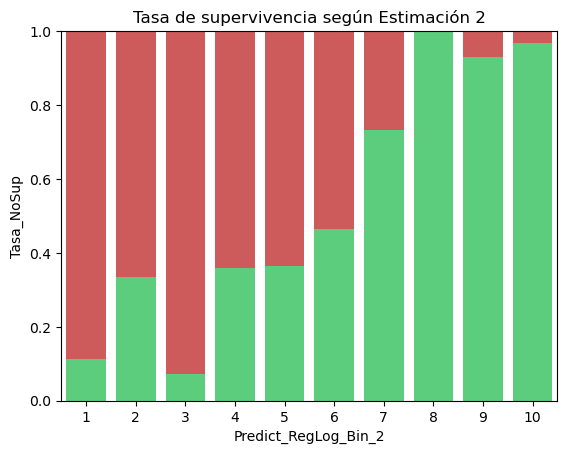

In [52]:
# Barplot por nodo 
resultados_nodo['Tasa_NoSup'] = (1 - resultados_nodo['Tasa_Sup'])
sns.barplot(data = resultados_nodo,
            x = 'Predict_RegLog_Bin_2',
            y = 'Tasa_Sup', 
            label = 'Porcentaje Supervivencia',
            color = '#48E074')
sns.barplot(data=resultados_nodo, 
            x = 'Predict_RegLog_Bin_2', 
            y = 'Tasa_NoSup', 
            bottom=resultados_nodo['Tasa_Sup'], 
            label = 'Porcentaje No Supervivencia',
            color = '#E04848')
plt.title('Tasa de supervivencia según Estimación 2')

Text(0.5, 1.0, 'Distribución de personas según Estimación 2')

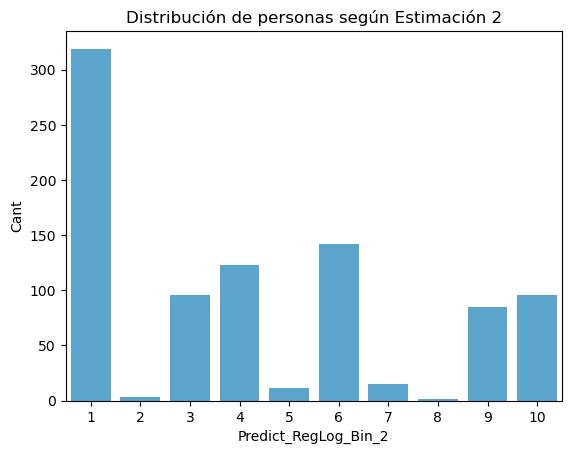

In [53]:
# Distribución
sns.barplot(data = resultados_nodo,
            x = 'Predict_RegLog_Bin_2',
            y = 'Cant',
           color = '#48ABE0')
plt.title('Distribución de personas según Estimación 2')